# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
proj_name = "simulation_treehard_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun13-1339'

In [5]:
group_key = 'depth'
batch_key = 'batch'
state_key = 'branch'
leiden_key = 'leiden_no_noise'
time_key = 'time'
state_type = 'tree'
batch_type = 'batch_specific_features'
distribution = 'normal'

In [6]:
from concord.utils.simulation import (
    Simulation,
    SimConfig,
    TreeConfig,
    BatchConfig,
)

# ── 1. global settings ──────────────────────────────────────────────
sim_cfg = SimConfig(
    n_cells = 6_000,
    n_genes = 3_000,
    seed    = 42,
    non_neg = True,
    to_int  = True,
)

# ── 2. state / tree settings ───────────────────────────────────────
tree_cfg = TreeConfig(
    # generic state parameters
    distribution   = "normal",
    level          = 10,      # <- state_level
    min_level      = 1,       # <- state_min_level
    dispersion     = 5.0,     # <- state_dispersion

    # tree-specific knobs (straight copy of your old call)
    branching_factor        = [3, 5, 8],
    depth                   = 3,
    program_structure       = "linear_increasing",
    program_on_time_fraction= 0.2,
    program_decay           = 0.4,
    cellcount_decay         = 0.5,
    # program_gap_size, noise_in_block, initial_inherited_genes keep defaults
)

# ── 3. batch settings (only one batch in the old call) ─────────────
batch_cfg = BatchConfig(
    n_batches    = 1,
    effect_type  = "batch_specific_features",
    distribution = "normal",
    level        = 10,        # same value for the single batch
    dispersion   = 5.0,
    feature_frac = 0.1,       # → 0.1 was the old default; change if needed
    # cell_proportion defaults to [1.0] because n_batches == 1
)

# ── 4. run the simulation ──────────────────────────────────────────
sim   = Simulation(sim_cfg, tree_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()

adata.layers["counts"] = adata.X.copy()


In [7]:
adata.shape

(4620, 1471)

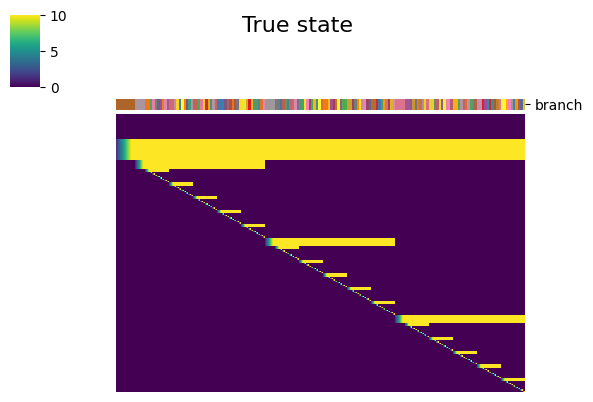

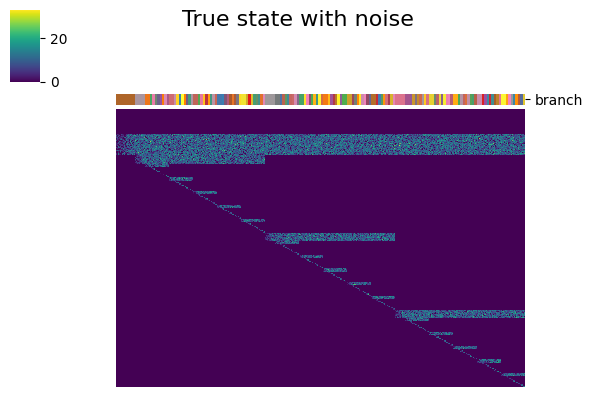

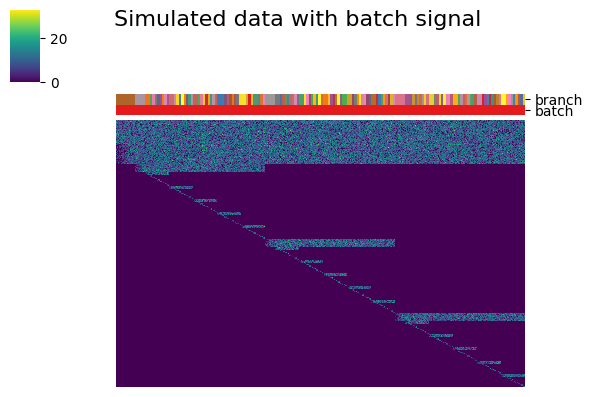

In [9]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

### No batch effect, no noise

In [10]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

Concord - INFO - PCA performed on source data with 15 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


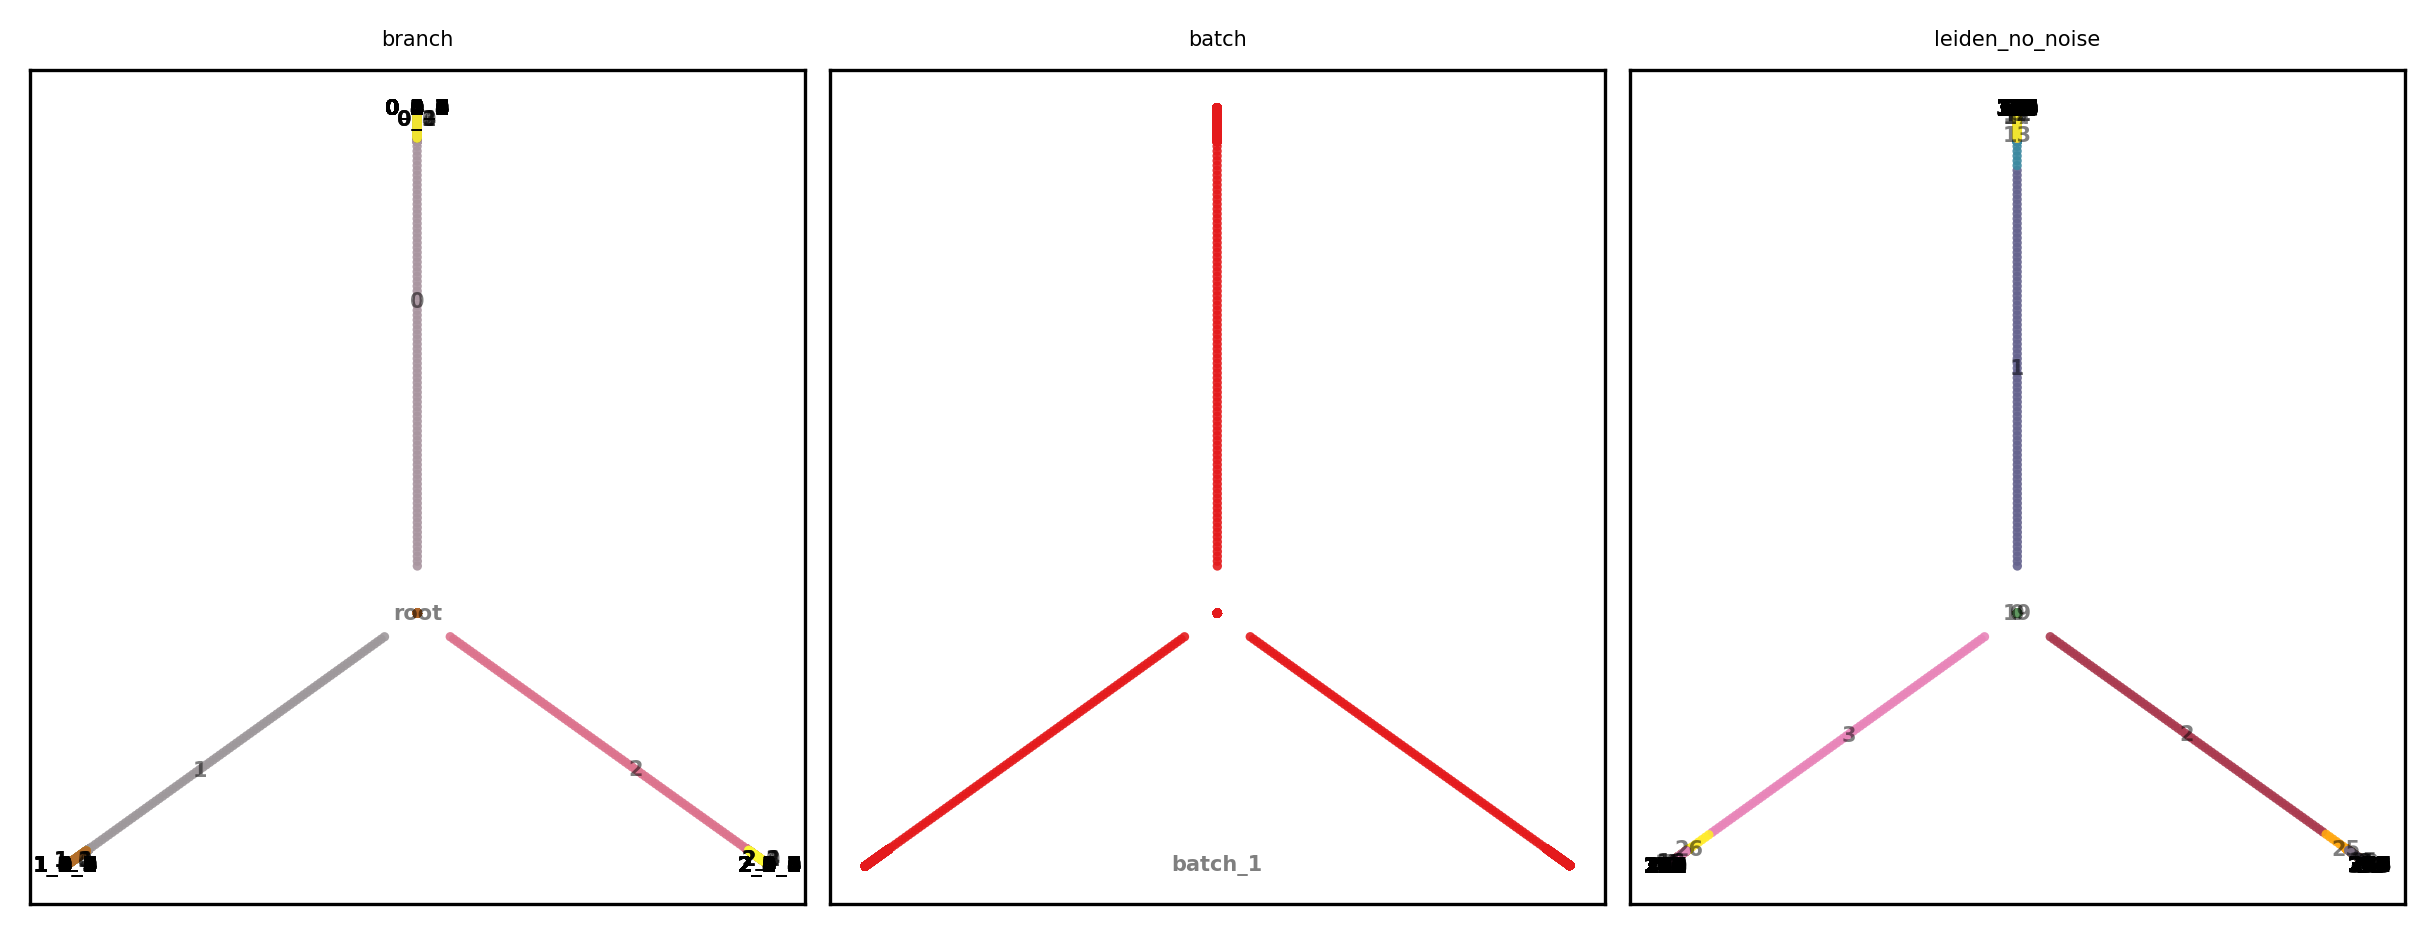

In [11]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

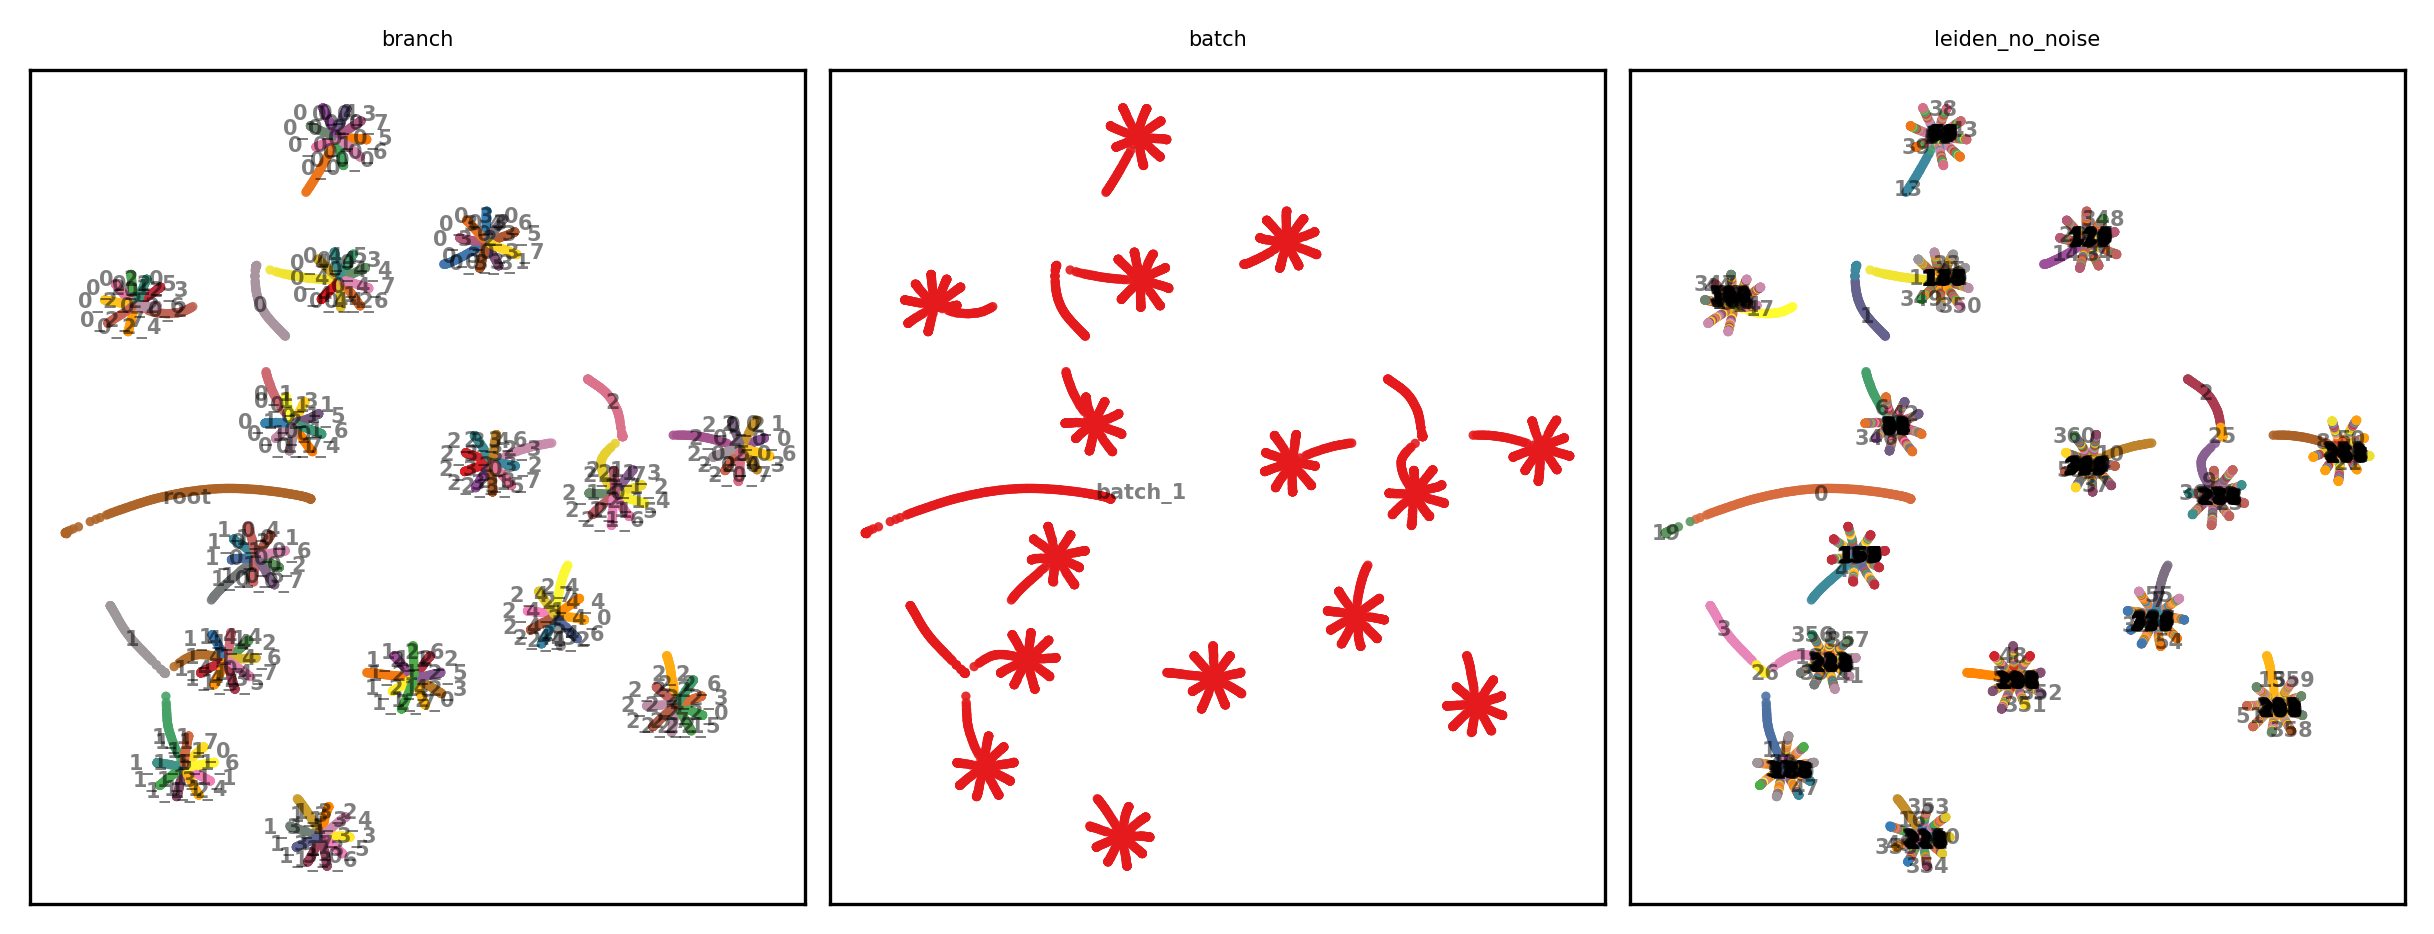

In [12]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### Concord

In [13]:
import copy
concord_args_base = {
    'input_feature': None,
    'use_decoder': False,
    'latent_dim': 100,
    'encoder_dims':[300],
    'decoder_dims':[300],
    'batch_size':16,
    'n_epochs': 10,
    'p_intra_knn': 0.0,
    'lr': 1e-2,
    'schedule_ratio': 0.97,
    'augmentation_mask_prob': 0.3,
    'clr_temperature':0.2,
    'sampler_knn':100,
    'dist_metric':'euclidean',
    'domain_key': batch_key,
    'seed': seed,
    'device': device,
    'save_dir': save_dir
}

file_suffix = f"{time.strftime('%b%d-%H%M')}_batchsize{concord_args_base['batch_size']}_latentdim{concord_args_base['latent_dim']}"
file_suffix

'Jun13-1350_batchsize16_latentdim100'

In [14]:
# -------------------------------------
# 2. Prepare dictionary of parameter variations
#    (one parameter at a time)
# -------------------------------------
param_variations = {
    'p_intra_knn': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Example: vary p_intra_knn
    #'p_intra_knn': [0.0, 0.3, 0.5, 0.7, 1.0 ],  # Example: vary p_intra_knn
}
param_keys = []
# -------------------------------------
# 3. Loop over each parameter to vary
# -------------------------------------
for param_name, values in param_variations.items():
    print(f"\n[INFO] Varying '{param_name}' with possible values: {values}\n")
    
    for value in values:
        # 3a. Copy the base arguments
        concord_args = copy.deepcopy(concord_args_base)
        
        # 3b. Update the specific parameter we want to vary
        concord_args[param_name] = value
        
        # 3c. Indicate which param is varied and to which value
        output_key = f"Concord_{param_name}_{value}"
        umap_key   = output_key + '_UMAP'
        param_keys.append(output_key)
        print(f"[INFO] Running Concord with {param_name} = {value}")
        
        # -------------------------------------
        # 4. Run Concord
        # -------------------------------------
        cur_ccd = ccd.Concord(adata, **concord_args)

        # Encode data, saving the latent embedding in adata.obsm[output_key]
        cur_ccd.encode_adata(
            input_layer_key='X',
            output_key=output_key,
            preprocess=False
        )       

print("[DONE] Finished varying each parameter individually.")



[INFO] Varying 'p_intra_knn' with possible values: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

[INFO] Running Concord with p_intra_knn = 0.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.0


Epoch 0 Training: 288it [00:00, 302.50it/s, loss=0.832]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 339.71it/s, loss=0.768]


[INFO] Running Concord with p_intra_knn = 0.1
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.1


Epoch 0 Training: 288it [00:00, 300.63it/s, loss=1.02] 
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 305.18it/s, loss=0.983]


[INFO] Running Concord with p_intra_knn = 0.2
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.2


Epoch 0 Training: 288it [00:00, 310.25it/s, loss=0.989]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 339.97it/s, loss=0.895]


[INFO] Running Concord with p_intra_knn = 0.3
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 288it [00:00, 329.47it/s, loss=1.7]  
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 314.72it/s, loss=0.882]


[INFO] Running Concord with p_intra_knn = 0.4
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.4


Epoch 0 Training: 288it [00:00, 331.36it/s, loss=1.79]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 370.02it/s, loss=1.23] 


[INFO] Running Concord with p_intra_knn = 0.5
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.5


Epoch 0 Training: 288it [00:00, 324.36it/s, loss=2.06]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 337.70it/s, loss=1.26] 


[INFO] Running Concord with p_intra_knn = 0.6
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.6


Epoch 0 Training: 288it [00:00, 343.41it/s, loss=1.91]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 329.92it/s, loss=1.4]  


[INFO] Running Concord with p_intra_knn = 0.7
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.7


Epoch 0 Training: 288it [00:00, 316.02it/s, loss=2.64]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 324.05it/s, loss=1.89]


[INFO] Running Concord with p_intra_knn = 0.8
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.8


Epoch 0 Training: 288it [00:00, 332.39it/s, loss=2.79]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 336.86it/s, loss=1.53]


[INFO] Running Concord with p_intra_knn = 0.9
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.9


Epoch 0 Training: 288it [00:00, 332.79it/s, loss=2.94]
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 347.99it/s, loss=1.37]


[INFO] Running Concord with p_intra_knn = 1.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 1.0


Epoch 0 Training: 288it [00:00, 332.79it/s, loss=3.4] 
Epoch 9 Training: 100%|██████████| 288/288 [00:00<00:00, 336.77it/s, loss=1.42]


[DONE] Finished varying each parameter individually.


In [15]:
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
combined_keys = ['no_noise', 'wt_noise'] + param_keys
for key in combined_keys:
    ccd.ul.run_umap(adata, source_key=key, result_key=key + '_UMAP', random_state=seed, min_dist=0.5, metric='cosine')

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams
file_suffix = f"{time.strftime('%b%d-%H%M')}"
# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

#color_bys = [state_key, batch_key]
color_bys = [state_key]
pal={
    'cluster': 'tab10',
    'batch': 'Set2',
}
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['KNN', 'UMAP']
font_size=8
point_size=1
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
k=15
edges_color='grey'
edges_width=0.01
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )


In [ ]:
adata.obsm['p_knn=0.0']

In [ ]:
adata_sub

In [ ]:
adata[adata.obs['depth']==1].obs['branch'].unique()

In [ ]:
adata.obs['depth'].value_counts()

In [ ]:
adata.obs['branch'].unique()

In [ ]:
show_branches = adata[adata.obs['depth']==1].obs['branch'].unique()
show_keys = [] 
for key in combined_keys:
    key_new = f"p_knn={key.split('_')[-1]}" if 'p_intra_knn' in key else key
    adata.obsm[key_new] = adata.obsm[key]
    show_keys.append(key_new)

for show_branch in show_branches:
    # Change the names of combined_keys for easy plotting, like Concord_p_intra_knn_0.0 to p_knn=0.0
    adata_sub = adata[adata.obs['branch'].str.startswith(show_branch)].copy()

    basis_types = ['KNN']
    font_size=8
    point_size=20
    alpha=0.8
    figsize=(0.9*len(combined_keys),1)
    ncols = len(combined_keys)
    nrows = int(np.ceil(len(param_keys) / ncols))
    k=15

    with plt.rc_context(rc=custom_rc):
        ccd.pl.plot_all_embeddings(
            adata_sub,
            show_keys,
            color_bys=color_bys,
            basis_types=basis_types,
            pal=pal,
            k=k,
            edges_color=edges_color,
            edges_width=edges_width,
            layout=layout,
            threshold=threshold,
            node_size_scale=node_size_scale,
            edge_width_scale=edge_width_scale,
            font_size=font_size,
            point_size=point_size,
            alpha=alpha,
            figsize=figsize,
            ncols=ncols,
            seed=seed,
            leiden_key='leiden',
            save_dir=save_dir,
            file_suffix=file_suffix + f'_branch{show_branch}',
            save_format='pdf'
        )


In [ ]:
# Highlight cells in branch 0_4 in global knn
show_branch = '2_0'
hl_cells = adata.obs['branch'].str.startswith(show_branch)
hl_cell_indices = np.where(hl_cells)[0]
font_size=8
point_size=1
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
k=15
edges_color='grey'
edges_width=0.01
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        highlight_indices = hl_cell_indices,
        highlight_size=point_size,
        file_suffix=file_suffix+f'hl_cells_branch{show_branch}',
        save_format='pdf'
    )


In [ ]:
# Zoom in to one of the branches


In [ ]:
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord_p_intra_knn_0.0', path=batch_indices, sigma=2)
adata.obsm['Concord_p_intra_knn_0.0_sorted'] = adata.obsm['Concord_p_intra_knn_0.0'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord_p_intra_knn_0.3', path=batch_indices, sigma=2)
adata.obsm['Concord_p_intra_knn_0.3_sorted'] = adata.obsm['Concord_p_intra_knn_0.3'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord_p_intra_knn_0.5', path=batch_indices, sigma=2)
adata.obsm['Concord_p_intra_knn_0.5_sorted'] = adata.obsm['Concord_p_intra_knn_0.5'][:, feature_order]

In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 6
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_p_intra_knn_0.0_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord_p_intra_knn_0.0_sorted', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_p_intra_knn_0.3_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord_p_intra_knn_0.3_sorted', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_p_intra_knn_0.5_sorted', obs_keys=[state_key, batch_key], ax = axes[5], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord_p_intra_knn_0.5_sorted', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

# Evaluation

In [ ]:
adata = sc.read(data_dir / f"adata_Feb07-1524.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Feb07-1524.h5ad")

In [ ]:
adata.obsm.keys()

In [ ]:
param_keys = [f'Concord_p_intra_knn_{val:.1f}' for val in np.linspace(0.0, 1.0, 11)]
param_keys
combined_keys = ['no_noise', 'wt_noise'] + param_keys
combined_keys

### Topology

Run topological analysis pipeline:

In [ ]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder", "Concord-pknn0"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys_topo = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys_topo

In [ ]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys_topo:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

In [ ]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

In [ ]:
import pickle
with open(Path('../save/dev_simulation_clustereasy_singlebatch-Dec15/topology_diagrams_Feb06-1037.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

In [ ]:
expected_betti_numbers = [2,0,0]
max_betti = np.max(expected_betti_numbers)
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=expected_betti_numbers, save_dir=save_dir, file_suffix=file_suffix)
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=2 * max_betti)
topology_metrics

In [ ]:
topology_df = topology_metrics.copy()

# Rename row name "no_noise_PCA" to "no_noise", "wt_noise_PCA" to "wt_noise"
topology_df.rename(
    index={
        "no_noise_PCA": "no_noise",
        "wt_noise_PCA": "wt_noise"
    },
    inplace=True
)

topology_df[("Topological metrics", "Betti curve stability")] = topology_df["Betti curve"][
    ["Entropy"]
]
topology_df[("Topological metrics", "Betti number accuracy")] = topology_df["Betti number"][
    ["L1 distance"]
]

topology_df.drop(
    columns=[
        ("Betti curve", "Variance"),
        ("Betti curve", "Entropy"),
        ("Betti number", "L1 distance")
    ],
    inplace=True
)

topology_df


In [ ]:
agg_name1 = ''
agg_name2 = 'Topology Score'
drop_methods = ['Concord-decoder', 'Concord-pknn0']
topology_scores = ccd.ul.benchmark_stats_to_score(topology_df.drop(index=drop_methods), min_max_scale=True, one_minus=True, aggregate_score=False, aggregate_score_name1=None, aggregate_score_name2=None, rank=False, rank_col=None, name_exact=False)
# Weight the metrics
topology_scores[("", "Topology Score")] = topology_scores[("Topological metrics", "Betti curve stability")]*0.2 + topology_scores[("Topological metrics", "Betti number accuracy")]*0.8
topology_scores.sort_values(by=("", "Topology Score"), ascending=False, inplace=True)
topology_scores

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys_topo}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

### Graph Connectivity

In [ ]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'no_noise','(wn)': 'wt_noise'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)

In [ ]:
connectivity_df[("Graph metrics", "Graph Similarity (n.n.)")] = connectivity_df["Graph connectivity"][
    ["jaccard(nn)", "hamming(nn)"]
].mean(axis=1)
connectivity_df[("Graph metrics", "Graph Similarity (w.n.)")] = connectivity_df["Graph connectivity"][
    ["jaccard(wn)", "hamming(wn)"]
].mean(axis=1)

connectivity_df.drop(
    columns=[
        ("Graph connectivity", "jaccard(nn)"),
        ("Graph connectivity", "hamming(nn)"),
        ("Graph connectivity", "jaccard(wn)"),
        ("Graph connectivity", "hamming(wn)")
    ],
    inplace=True
)
connectivity_df


In [ ]:
agg_name1 = ''
agg_name2 = 'Graph Score'
#drop_methods = ['Concord-decoder', 'Concord-pknn0']
drop_methods = []
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df.drop(index=drop_methods), min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
# Drop row with 'Concord-decoder'
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(7, 7), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [ ]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'wt_noise'
groundtruth_key = 'no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = state_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

In [ ]:
# Save results with pickle
import pickle
with open(save_dir / f"geometry_full_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(geometry_full, f)

with open(save_dir / f"geometry_df_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(geometry_df, f)

print(f"Saved geometry results to {save_dir / f'geometry_full_{file_suffix}.pkl'} and {save_dir / f'geometry_df_{file_suffix}.pkl'}")

In [ ]:
# Simplify the dataframe by computing average for each metric
geometry_df = ccd.ul.simplify_geometry_benchmark_table(geometry_df)
geometry_df

In [ ]:
agg_name1 = ''
agg_name2 = 'Geometric Score'
drop_methods = []
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=drop_methods), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
geometry_scores


In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(8.5, 7), dpi=300)

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 13, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

In [ ]:
trustworthiness_scores

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = ['Concord-pknn0', 'Concord-decoder']
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, fontsize=3, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

In [ ]:
trustworthiness_zoom

In [ ]:
# Zoom in to neighbors < 40
x_cut = 20
y_cut = 0.95
trustworthiness_zoom = trustworthiness_scores[(trustworthiness_scores['n_neighbors'] <= x_cut) & (trustworthiness_scores['Trustworthiness'] > y_cut)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_zoom, text_shift=2, fontsize=3, legend=False, save_path=save_dir / f"trustworthiness_zoom{x_cut}_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

## Combine all metrics

In [ ]:
# Combine all metrics into one table
import pandas as pd
all_scores = pd.concat([geometry_scores, connectivity_scores], axis=1)
all_scores

In [ ]:
#all_scores[('Aggregate score', 'Topology')] = all_scores[('', 'Topology Score')]
all_scores[('Aggregate score', 'Geometry')] = all_scores[('', 'Geometric Score')]
all_scores[('Aggregate score', 'Graph')] = all_scores[('', 'Graph Score')]
all_scores[('Aggregate score', 'Average Score')] = all_scores["Aggregate score"][["Geometry", "Graph"]].mean(axis=1)
# sort by average score
all_scores.sort_values(by=[('Aggregate score', 'Average Score')], ascending=False, inplace=True)
all_scores.drop(
    columns=[
        ('', 'Graph Score'),
        ('', 'Geometric Score')
    ],
    inplace=True
)
# Save table
all_scores.to_csv(save_dir / f"benchmark_results_{file_suffix}.csv")
all_scores

In [ ]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(all_scores, pal='PRGn', pal_agg='RdBu_r', cmap_method = 'minmax', agg_name = 'Aggregate score', save_path=save_dir / f"all_results_{file_suffix}.pdf", figsize=(15, 7), dpi=300)